In [1]:
# Cell 1 — imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

# plotting defaults
plt.rcParams.update({'figure.max_open_warning': 50, 'font.size': 10})

In [2]:
# Cell 2 — raw INP snippets (from your message) and simple parser

inp_nodes_text = """
       1,       -94.20163726309161,       3.0303030000000017,                 5.652396
       2,          -94.20163726309161,          3.751702126589781,          0.0
       3,          -94.20163726309161,          3.0733534334008734,          3.31365423269048
       4,          -94.20163726309161,          8.676279168533132,          0.0
       5,          -94.20163726309161,          3.3995865702584034,          2.941934626109802
       6,       -94.20163726309161,   3.1086244689504383E-15,                 5.652396
       7,          -94.20163726309161,          7.354721352535645,          2.4594220322105125
       8,       -94.20163726309161,                 6.060606,                 5.652396
       9,          -94.20163726309161,          0.5728504162228081,          0.480198653935908
"""

inp_elems_text = """
       1,        1,        3,        7,        8
       2,        3,        1,        6,        5
       3,        2,        3,        5,        9
       6,        3,        2,        4,        7
"""

def parse_nodes(text):
    nodes = {}
    for line in text.strip().splitlines():
        parts = [p.strip() for p in line.split(',') if p.strip()!='']
        if len(parts) >= 4:
            nid = int(parts[0])
            # Abaqus order in these lines: X, Y, Z  -> we'll use (Y,Z) as 2D coordinates
            x = float(parts[1]); y = float(parts[2]); z = float(parts[3])
            nodes[nid] = np.array([y, z], dtype=float)
    return nodes

def parse_quads(text):
    quads = {}
    for line in text.strip().splitlines():
        parts = [p.strip() for p in line.split(',') if p.strip()!='']
        if len(parts) >= 5:
            eid = int(parts[0])
            conn = [int(x) for x in parts[1:5]]
            quads[eid] = conn
    return quads

nodes = parse_nodes(inp_nodes_text)
quads = parse_quads(inp_elems_text)

print("Parsed nodes:", len(nodes), "nodes")
for k,v in nodes.items():
    print(k, v)
print("\nParsed quad elements:", quads)


Parsed nodes: 9 nodes
1 [3.030303 5.652396]
2 [3.75170213 0.        ]
3 [3.07335343 3.31365423]
4 [8.67627917 0.        ]
5 [3.39958657 2.94193463]
6 [3.10862447e-15 5.65239600e+00]
7 [7.35472135 2.45942203]
8 [6.060606 5.652396]
9 [0.57285042 0.48019865]

Parsed quad elements: {1: [1, 3, 7, 8], 2: [3, 1, 6, 5], 3: [2, 3, 5, 9], 6: [3, 2, 4, 7]}


In [3]:
# Cell 3 — convert quads -> triangles and prepare mapping arrays
tri_elems = []
for eid,conn in quads.items():
    n1,n2,n3,n4 = conn
    # Two triangles (n1,n2,n3) and (n1,n3,n4)
    tri_elems.append({'eid': eid*10+1, 'conn': [n1,n2,n3]})
    tri_elems.append({'eid': eid*10+2, 'conn': [n1,n3,n4]})

# Node ordering and index mapping (node IDs -> row index 0..)
node_ids = sorted(nodes.keys())
nid_to_idx = {nid:i for i,nid in enumerate(node_ids)}
coords_mat = np.array([nodes[nid] for nid in node_ids])  # Nx2 array (Y,Z)

print("Total triangular elements:", len(tri_elems))
print("Node index map:", nid_to_idx)


Total triangular elements: 8
Node index map: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8}


In [4]:
# Cell 4 — material properties (from INP) and plane-stress D matrix
E = 40000.0
nu = 0.3
thickness = 0.8

# plane-stress constitutive matrix (3x3)
D = (E / (1 - nu**2)) * np.array([[1.0, nu, 0.0],
                                  [nu, 1.0, 0.0],
                                  [0.0, 0.0, (1-nu)/2]])
print("Material: E=", E, "nu=", nu, "thickness=", thickness)


Material: E= 40000.0 nu= 0.3 thickness= 0.8


In [5]:
# Cell 5 — element routines and assembly
def tri_area_and_B(coords):
    # coords: 3x2 array with rows [y,z] (we treat them as x,y for 2D formulas)
    x1,y1 = coords[0]
    x2,y2 = coords[1]
    x3,y3 = coords[2]
    A = 0.5 * ((x2 - x1)*(y3 - y1) - (x3 - x1)*(y2 - y1))
    if abs(A) < 1e-12:
        raise ValueError("Tiny/zero triangle area")
    # linear triangle B matrix (exx, eyy, exy)
    b1 = y2 - y3; b2 = y3 - y1; b3 = y1 - y2
    c1 = x3 - x2; c2 = x1 - x3; c3 = x2 - x1
    B = (1.0 / (2.0 * A)) * np.array([
        [b1,   0, b2,   0, b3,   0],
        [0,  c1,  0, c2,  0, c3],
        [c1, b1, c2, b2, c3, b3]
    ])
    return float(abs(A)), B

# assemble
ndof = 2 * len(node_ids)
K = np.zeros((ndof, ndof))
elem_data = []   # store element info for postprocessing

for ed in tri_elems:
    conn = ed['conn']
    coords = np.array([nodes[n] for n in conn])
    A, B = tri_area_and_B(coords)
    ke = thickness * A * (B.T @ D @ B)   # 6x6 for triangle (u1,v1,u2,v2,u3,v3)
    # assemble into global K
    dof_map = []
    for n in conn:
        i = nid_to_idx[n]
        dof_map += [2*i, 2*i+1]
    for i_local in range(6):
        for j_local in range(6):
            K[dof_map[i_local], dof_map[j_local]] += ke[i_local, j_local]
    elem_data.append({'eid': ed['eid'], 'conn': conn, 'A': A, 'B': B, 'ke': ke})

print("Assembled global stiffness K of shape:", K.shape)


Assembled global stiffness K of shape: (18, 18)


In [6]:
# Cell 6 — loads and BCs (explicit as per INP)
# From INP: *NSET, NSET=LOAD_SET -> node 2; *CLOAD load_set, 3, -11998.93671200517
load_node = 2
load_value = -11998.93671200517  # as in INP (units are model units)
# DOF mapping: we treat node DOFs as [U_y, U_z] i.e. Abaqus U2->y, U3->z
F = np.zeros(ndof)
F[2 * nid_to_idx[load_node] + 1] = load_value  # apply on second DOF (z)

# Boundary set DOF_3 contains nodes 1,6,8 -> *BOUNDARY, FIXED DOF_3, 1, 6 (interpreted earlier as fix both in-plane DOFs)
fixed_nodes = [1, 6, 8]
fixed_dofs = []
for n in fixed_nodes:
    i = nid_to_idx[n]
    fixed_dofs += [2*i, 2*i+1]
free_dofs = [i for i in range(ndof) if i not in fixed_dofs]

print("Force vector F (non-zero entries):", [(i, F[i]) for i in range(len(F)) if abs(F[i])>0])
print("Fixed DOFs:", fixed_dofs)


Force vector F (non-zero entries): [(3, -11998.93671200517)]
Fixed DOFs: [0, 1, 10, 11, 14, 15]


In [7]:
# Cell 7 — solve K * U = F with fixed DOFs eliminated
Kff = K[np.ix_(free_dofs, free_dofs)]
Ff = F[free_dofs]
# Solve (fallback to pseudoinverse if singular)
try:
    U_free = np.linalg.solve(Kff, Ff)
except np.linalg.LinAlgError:
    U_free = np.linalg.pinv(Kff) @ Ff

U = np.zeros(ndof)
U[free_dofs] = U_free

# print nodal displacements (U_y, U_z)
print("Nodal displacements (U_y, U_z):")
for nid in node_ids:
    i = nid_to_idx[nid]
    print(f"Node {nid:2d}: Uy = {U[2*i]: .8e}, Uz = {U[2*i+1]: .8e}")


Nodal displacements (U_y, U_z):
Node  1: Uy =  0.00000000e+00, Uz =  0.00000000e+00
Node  2: Uy =  1.70820597e-01, Uz = -4.36842696e-01
Node  3: Uy =  5.21352676e-02, Uz = -1.93305761e-01
Node  4: Uy =  3.23739072e-02, Uz = -1.41492559e-01
Node  5: Uy =  6.20961316e-02, Uz = -2.23516613e-01
Node  6: Uy =  0.00000000e+00, Uz =  0.00000000e+00
Node  7: Uy =  4.36403429e-03, Uz = -1.17515084e-01
Node  8: Uy =  0.00000000e+00, Uz =  0.00000000e+00
Node  9: Uy =  2.19753161e-01, Uz = -4.52724601e-01


In [8]:
# Cell 8 — compute element strains/stresses and von Mises, and nodal displacement magnitudes
U_nodes = np.array([[U[2*i], U[2*i+1]] for i in range(len(node_ids))])
disp_mag = np.linalg.norm(U_nodes, axis=1)

elem_vm = []
elem_centroids = []
for ed in elem_data:
    conn = ed['conn']
    # assemble element nodal displacement vector (u1,v1,u2,v2,u3,v3)
    u_e = np.zeros(6)
    for local_idx, nid in enumerate(conn):
        idx = nid_to_idx[nid]
        u_e[2*local_idx] = U[2*idx]
        u_e[2*local_idx+1] = U[2*idx+1]
    strain = ed['B'] @ u_e            # [exx, eyy, exy]
    stress = D @ strain               # plane stress
    sxx, syy, sxy = stress[0], stress[1], stress[2]
    von = np.sqrt(sxx*sxx - sxx*syy + syy*syy + 3*(sxy**2))
    elem_vm.append(von)
    # element centroid in our (Y,Z) coordinates for region classification
    centroid = np.mean(np.array([nodes[n] for n in conn]), axis=0)
    elem_centroids.append(centroid)

elem_vm = np.array(elem_vm)
elem_centroids = np.array(elem_centroids)

print("Element von Mises (per triangular element):", elem_vm)


Element von Mises (per triangular element): [3283.71928059 1438.36677777 3283.37814202 3236.77360029 3094.79413466
 3033.95667878 3487.67677024  995.72858072]


In [9]:
# Cell 9 — define regions by radial distance from mesh centroid
mesh_centroid = coords_mat.mean(axis=0)   # (y_center, z_center)
# compute node distances
node_distances = {nid: np.linalg.norm(nodes[nid] - mesh_centroid) for nid in node_ids}
Rmax = max(node_distances.values())

# thresholds
r1 = Rmax / 3.0
r2 = 2.0 * Rmax / 3.0

regions_nodes = {'central': [], 'narrow': [], 'border': []}
for nid, r in node_distances.items():
    if r < r1:
        regions_nodes['central'].append(nid)
    elif r < r2:
        regions_nodes['narrow'].append(nid)
    else:
        regions_nodes['border'].append(nid)

# classify elements by centroid
regions_elems = {'central': [], 'narrow': [], 'border': []}
for i, centroid in enumerate(elem_centroids):
    r = np.linalg.norm(centroid - mesh_centroid)
    if r < r1:
        regions_elems['central'].append(i)   # store element index
    elif r < r2:
        regions_elems['narrow'].append(i)
    else:
        regions_elems['border'].append(i)

print("Mesh centroid (Y,Z):", mesh_centroid)
print("Region node counts:", {k: len(v) for k,v in regions_nodes.items()})
print("Region element counts:", {k: len(v) for k,v in regions_elems.items()})


Mesh centroid (Y,Z): [3.99104467 2.90582195]
Region node counts: {'central': 2, 'narrow': 4, 'border': 3}
Region element counts: {'central': 2, 'narrow': 6, 'border': 0}


In [10]:
# Cell 10 — compute and print averages by region
def region_node_stats(region_nodes):
    if not region_nodes:
        return {'n':0, 'avg_disp':0.0, 'max_disp':0.0}
    idxs = [nid_to_idx[nid] for nid in region_nodes]
    dvals = disp_mag[idxs]
    return {'n': len(idxs), 'avg_disp': float(np.mean(dvals)), 'max_disp': float(np.max(dvals))}

def region_elem_stats(region_elem_idxs):
    if not region_elem_idxs:
        return {'m':0, 'avg_vm':0.0, 'max_vm':0.0}
    vvals = elem_vm[region_elem_idxs]
    return {'m': len(region_elem_idxs), 'avg_vm': float(np.mean(vvals)), 'max_vm': float(np.max(vvals))}

print("=== REGION SUMMARY ===")
for key in ['central','narrow','border']:
    ns = region_node_stats(regions_nodes[key])
    es = region_elem_stats(regions_elems[key])
    print(f"\nRegion: {key.upper()}")
    print(f"  Nodes: {ns['n']}, Avg displacement: {ns['avg_disp']:.6e}, Max displacement: {ns['max_disp']:.6e}")
    print(f"  Elements: {es['m']}, Avg von Mises: {es['avg_vm']:.6e}, Max von Mises: {es['max_vm']:.6e}")


=== REGION SUMMARY ===

Region: CENTRAL
  Nodes: 2, Avg displacement: 2.160974e-01, Max displacement: 2.319819e-01
  Elements: 2, Avg von Mises: 3.189257e+03, Max von Mises: 3.283719e+03

Region: NARROW
  Nodes: 4, Avg displacement: 1.466624e-01, Max displacement: 4.690535e-01
  Elements: 6, Avg von Mises: 2.579313e+03, Max von Mises: 3.487677e+03

Region: BORDER
  Nodes: 3, Avg displacement: 2.161298e-01, Max displacement: 5.032405e-01
  Elements: 0, Avg von Mises: 0.000000e+00, Max von Mises: 0.000000e+00


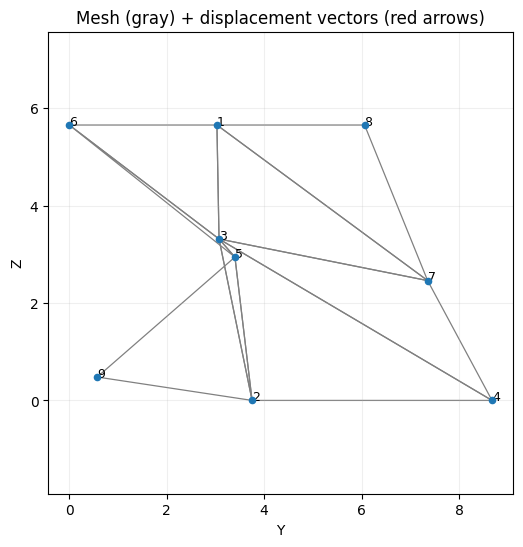

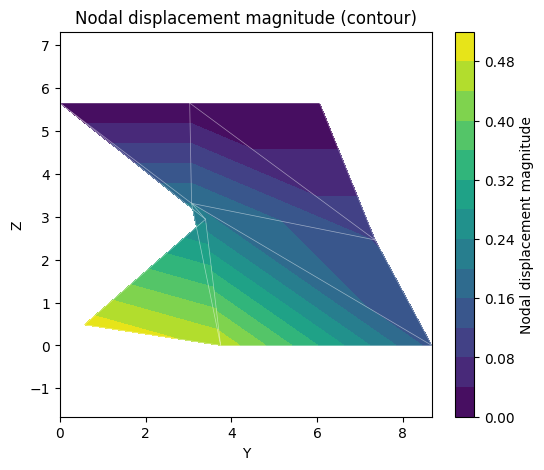

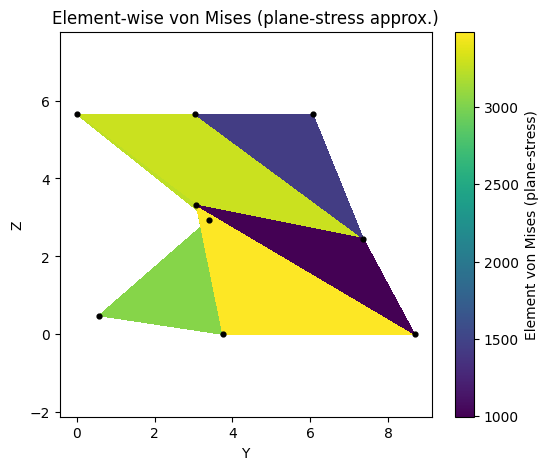

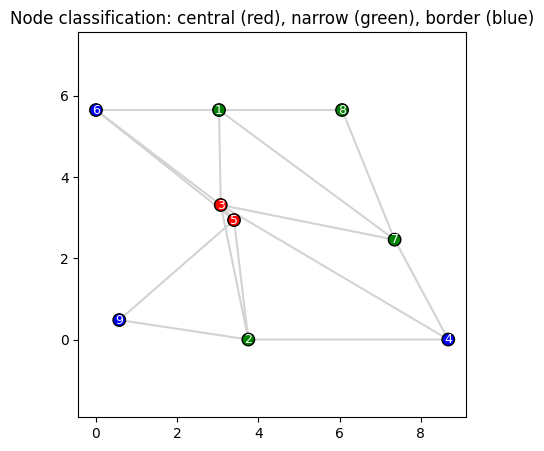

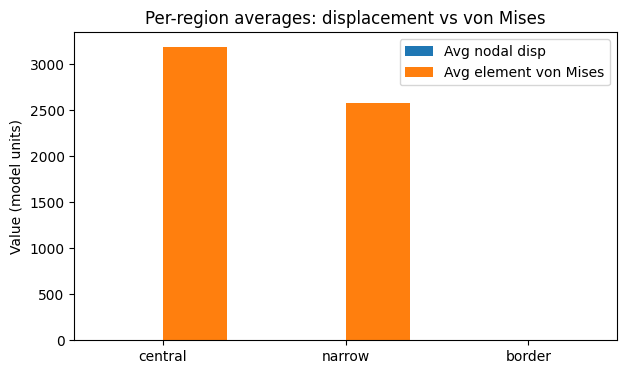

In [11]:
# Cell 11 — plots

# prepare triangulation indices for plotting (map node ids -> local indices 0..N-1)
tri_indices = np.array([[nid_to_idx[n] for n in ed['conn']] for ed in tri_elems])

# 1) Mesh + quiver (displacement vectors)
plt.figure(figsize=(6,6))
for tri in tri_indices:
    pts = coords_mat[tri]
    plt.gca().add_patch(plt.Polygon(pts, fill=None, edgecolor='gray', linewidth=0.9))
# scale arrows for visibility
arrow_scale = np.max(disp_mag) * 15 if np.max(disp_mag) > 0 else 1.0
plt.quiver(coords_mat[:,0], coords_mat[:,1], U[0::2], U[1::2],
           angles='xy', scale_units='xy', scale=arrow_scale, color='red', width=0.003)
plt.scatter(coords_mat[:,0], coords_mat[:,1], s=20, zorder=5)
for i, nid in enumerate(node_ids):
    plt.text(coords_mat[i,0], coords_mat[i,1], str(nid), fontsize=9, color='black')
plt.title("Mesh (gray) + displacement vectors (red arrows)")
plt.xlabel("Y"); plt.ylabel("Z"); plt.axis('equal'); plt.grid(alpha=0.2)
plt.show()

# 2) Nodal displacement contour (node-based scalar)
triang = mtri.Triangulation(coords_mat[:,0], coords_mat[:,1], tri_indices)
plt.figure(figsize=(6,5))
cf = plt.tricontourf(triang, disp_mag, levels=12)
plt.colorbar(cf, label='Nodal displacement magnitude')
plt.triplot(triang, color='white', linewidth=0.5, alpha=0.5)
plt.title("Nodal displacement magnitude (contour)")
plt.xlabel("Y"); plt.ylabel("Z"); plt.axis('equal')
plt.show()

# 3) Element von Mises (element-based) using tripcolor (face values)
plt.figure(figsize=(6,5))
pc = plt.tripcolor(coords_mat[:,0], coords_mat[:,1], tri_indices, facecolors=elem_vm, shading='flat')
plt.colorbar(pc, label='Element von Mises (plane-stress)')
plt.scatter(coords_mat[:,0], coords_mat[:,1], s=12, color='k')
plt.title("Element-wise von Mises (plane-stress approx.)")
plt.xlabel("Y"); plt.ylabel("Z"); plt.axis('equal')
plt.show()

# 4) Nodes colored by region
colors_map = {'central':'red', 'narrow':'green', 'border':'blue'}
colors = [next((colors_map[r] for r in colors_map if nid in regions_nodes[r]), 'gray') for nid in node_ids]
plt.figure(figsize=(5,5))
plt.triplot(triang, color='lightgray')
plt.scatter(coords_mat[:,0], coords_mat[:,1], c=colors, s=80, edgecolors='k')
for i, nid in enumerate(node_ids):
    plt.text(coords_mat[i,0], coords_mat[i,1], str(nid), fontsize=9, color='white', ha='center', va='center')
plt.title("Node classification: central (red), narrow (green), border (blue)")
plt.axis('equal'); plt.show()

# 5) Bar chart: average nodal displacement & average element von Mises per region
regions = ['central','narrow','border']
avg_disp = [region_node_stats(regions_nodes[r])['avg_disp'] for r in regions]
avg_vm = [region_elem_stats(regions_elems[r])['avg_vm'] for r in regions]

x = np.arange(len(regions))
width = 0.35
plt.figure(figsize=(7,4))
plt.bar(x - width/2, avg_disp, width, label='Avg nodal disp')
plt.bar(x + width/2, avg_vm, width, label='Avg element von Mises')
plt.xticks(x, regions)
plt.ylabel('Value (model units)')
plt.title('Per-region averages: displacement vs von Mises')
plt.legend()
plt.show()


In [12]:
# Cell 12 — Abaqus DAT nodal results (from your DAT snippet)
# DAT columns: NODE, U1, U2, U3, UR1, UR2, UR3
abaqus_dat = {
    2: {'U2': 6.3913083E-01, 'U3': -8.0421002E-01},
    3: {'U2': 1.2584936E-01, 'U3': -2.9018070E-01},
    4: {'U2': 8.2453777E-01, 'U3': 9.2126502E-01},
    5: {'U2': 1.8547947E-01, 'U3': -3.7633331E-01},
    7: {'U2': 6.8571494E-02, 'U3': 1.3421406E-01},
    9: {'U2': 6.8906124E-01, 'U3': -1.0128338E+00}
}

# compute relative errors node-by-node where Abaqus data is available
errors = []
print("Node   Abaqus(Uy,Uz)        FEM(Uy,Uz)         RelErr_y   RelErr_z")
for nid, vals in abaqus_dat.items():
    if nid not in nid_to_idx:
        continue
    idx = nid_to_idx[nid]
    uy_aba, uz_aba = vals['U2'], vals['U3']
    uy_sim, uz_sim = U[2*idx], U[2*idx+1]
    rel_y = abs((uy_sim - uy_aba) / (uy_aba if abs(uy_aba) > 1e-12 else 1.0))
    rel_z = abs((uz_sim - uz_aba) / (uz_aba if abs(uz_aba) > 1e-12 else 1.0))
    errors.append((rel_y, rel_z))
    print(f"{nid:3d}  {uy_aba: .6e}, {uz_aba: .6e}   {uy_sim: .6e}, {uz_sim: .6e}   {rel_y:.3f}     {rel_z:.3f}")

flat = [e for pair in errors for e in pair]
mean_rel_error = float(np.mean(flat)) if flat else 0.0
print(f"\nMean relative error across available nodes & DOFs: {mean_rel_error:.3f}")

# per-region mean relative error (use nodes that have Abaqus data)
for r in ['central','narrow','border']:
    node_list = [nid for nid in regions_nodes[r] if nid in abaqus_dat]
    if not node_list:
        print(f"Region {r}: no Abaqus nodes available for error comparison.")
        continue
    rels = []
    for nid in node_list:
        idx = nid_to_idx[nid]
        uy_sim, uz_sim = U[2*idx], U[2*idx+1]
        uy_aba, uz_aba = abaqus_dat[nid]['U2'], abaqus_dat[nid]['U3']
        rel_y = abs((uy_sim - uy_aba) / (uy_aba if abs(uy_aba)>1e-12 else 1.0))
        rel_z = abs((uz_sim - uz_aba) / (uz_aba if abs(uz_aba)>1e-12 else 1.0))
        rels += [rel_y, rel_z]
    print(f"Region {r}: mean relative error (using available Abaqus nodes) = {np.mean(rels):.3f}")


Node   Abaqus(Uy,Uz)        FEM(Uy,Uz)         RelErr_y   RelErr_z
  2   6.391308e-01, -8.042100e-01    1.708206e-01, -4.368427e-01   0.733     0.457
  3   1.258494e-01, -2.901807e-01    5.213527e-02, -1.933058e-01   0.586     0.334
  4   8.245378e-01,  9.212650e-01    3.237391e-02, -1.414926e-01   0.961     1.154
  5   1.854795e-01, -3.763333e-01    6.209613e-02, -2.235166e-01   0.665     0.406
  7   6.857149e-02,  1.342141e-01    4.364034e-03, -1.175151e-01   0.936     1.876
  9   6.890612e-01, -1.012834e+00    2.197532e-01, -4.527246e-01   0.681     0.553

Mean relative error across available nodes & DOFs: 0.778
Region central: mean relative error (using available Abaqus nodes) = 0.498
Region narrow: mean relative error (using available Abaqus nodes) = 1.000
Region border: mean relative error (using available Abaqus nodes) = 0.837
